In [9]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from core_data_prep.core_data_prep import DataPreparer
from core_data_prep.validations import Validator

from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from data.raw.retrievers.stooq_retriever import StooqRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset
from modeling.modeling_utils import print_model_parameters

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.actors.allocation_propogation_actor import AllocationPropogationActor
from modeling.rl.actors.market_actor import MarketActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss, ReinforceLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [40]:
retriever = config.data_config.retriever
retrieval_result = retriever.bars_with_quotes(
    symbol_or_symbols=config.data_config.symbol_or_symbols, 
    start=config.data_config.start, 
    end=config.data_config.end
)

In [41]:
data_preparer = DataPreparer(
    normalizer=config.data_config.normalizer,
    missing_values_handler=config.data_config.missing_values_handler_polars,
    in_seq_len=config.data_config.in_seq_len,
    frequency=str(config.data_config.frequency),
    validator=config.data_config.validator
)

In [42]:
(X_train, y_train, statistics_train), (X_val, y_val, statistics_val), (X_test, y_test, statistics_test) = \
    data_preparer.get_experiment_data(
        data=retrieval_result,
        start_date=config.data_config.start,
        end_date=config.data_config.end,
        features=config.data_config.features_polars,
        statistics=config.data_config.statistics,
        target=config.data_config.target,
        train_set_last_date=config.data_config.train_set_last_date,
        val_set_last_date=config.data_config.val_set_last_date,
        backend='threading'
    )

X_train.shape, y_train.shape, statistics_train['next_return'].shape, \
    X_val.shape, y_val.shape, statistics_val['next_return'].shape, \
    X_test.shape, y_test.shape, statistics_test['next_return'].shape

2025-11-25 13:30:53,452 - INFO - Using monolithic slices with -60 timestamps
2025-11-25 13:30:54,794 - INFO - Found 6891 train slices, 502 val slices, 1258 test slices
2025-11-25 13:30:54,795 - INFO - Trained per-asset targets


((15249, 30, 30, 16),
 (15249, 30),
 (15249, 30),
 (640, 30, 30, 16),
 (640, 30),
 (640, 30),
 (1736, 30, 30, 16),
 (1736, 30),
 (1736, 30))

In [43]:
# from observability.mlflow_integration import log_experiment


# log_experiment(
#     config=config, 
#     validator_snapshots=data_preparer.validator.snapshots
#     # model=model, 
#     # history=history,
# )

In [44]:
next_return_train, spread_train, volatility_train, \
    next_return_val, spread_val, volatility_val, \
    next_return_test, spread_test, volatility_test = \
        statistics_train['next_return'], statistics_train['spread'], statistics_train['volatility'], \
        statistics_val['next_return'], statistics_val['spread'], statistics_val['volatility'], \
        statistics_test['next_return'], statistics_test['spread'], statistics_test['volatility']

In [45]:
np.abs(next_return_train).mean(), spread_train.mean(), volatility_train.mean()

(0.023848599, 0.0, 0.011072977)

In [46]:
np.abs(next_return_val).mean(), spread_val.mean(), volatility_val.mean()

(0.021187985, 0.0, 0.009740075)

In [47]:
np.abs(next_return_test).mean(), spread_test.mean(), volatility_test.mean()

(0.02138582, 0.0, 0.009769131)

In [48]:
train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
    batch_size=config.train_config.batch_size,
    shuffle=config.train_config.shuffle,
    num_workers=config.train_config.num_workers,
    prefetch_factor=config.train_config.prefetch_factor,
    pin_memory=config.train_config.pin_memory,
    persistent_workers=config.train_config.persistent_workers,
    drop_last=config.train_config.drop_last
)
val_loader = DatasetPytorch(X_val, y_val, learning_task='regression').as_dataloader(
    batch_size=config.train_config.batch_size,
    shuffle=config.train_config.shuffle,
    num_workers=config.train_config.num_workers,
    prefetch_factor=config.train_config.prefetch_factor,
    pin_memory=config.train_config.pin_memory,
    persistent_workers=config.train_config.persistent_workers,
    drop_last=config.train_config.drop_last
)

In [49]:
model = config.model_config.model
model

TSAllocator(
  (asset_embed): Embedding(30, 8)
  (asset_proj): Linear(in_features=8, out_features=128, bias=False)
  (lstm): LSTM(16, 64, batch_first=True, bidirectional=True)
  (spatial_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [50]:
print_model_parameters(model)

Module                                   Params
------------------------------------------------------------
[ROOT]                                   109681
asset_embed                              240
asset_proj                               1024
lstm                                     41984
spatial_attn                             66048
spatial_attn.out_proj                    16512
fc                                       129
norm                                     256


In [ ]:
config

ExperimentConfig(data_config=DataConfig(retriever=<data.raw.retrievers.stooq_retriever.StooqRetriever object at 0x000001CF44D76990>, symbol_or_symbols=['MMM', 'AXP', 'AMGN', 'AMZN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'NVDA', 'PG', 'CRM', 'SHW', 'TRV', 'UNH', 'VZ', 'V', 'WMT'], frequency=<alpaca.data.timeframe.TimeFrame object at 0x000001CF438D3740>, start=datetime.datetime(1970, 1, 2, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')), end=datetime.datetime(2019, 1, 1, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')), train_set_last_date=datetime.datetime(2012, 1, 1, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')), val_set_last_date=datetime.datetime(2000, 1, 1, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')), features_polars={'log_ret': <function <lambda> at 0x000001CF42D8E160>, 'hl_range': <function <lambda> at 0x000001CF44FADBC0>, 'close_open': <function <lambda> at 0x00000

In [52]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=config.train_config.loss_fn,
    optimizer=config.train_config.optimizer,
    scheduler=config.train_config.scheduler,
    num_epochs=config.train_config.num_epochs,
    early_stopping_patience=config.train_config.early_stopping_patience,
    device=config.train_config.device,
    metrics=config.train_config.metrics,
    save_path=config.train_config.save_path
)

2025-11-25 13:31:02,710 - INFO - Model compiled with torch.compile()


In [53]:
model, history = trainer.train()

2025-11-25 13:31:20,289 - INFO - Epoch 1/20


BackendCompilerFailed: backend='inductor' raised:
RuntimeError: Cannot find a working triton installation. Either the package is not installed or it is too old. More information on installing Triton can be found at https://github.com/openai/triton

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [ ]:
train_trajectory_loader = TrajectoryDataset(X_train, next_return_train, spread_train, volatility_train, \
        trajectory_length=config.rl_config.trajectory_length, horizon=config.data_config.horizon, shift_data_within_horizon=True).as_dataloader(
    batch_size=8, 
    shuffle=True,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
)
val_trajectory_loader = TrajectoryDataset(X_val, next_return_val, spread_val, volatility_val, \
        trajectory_length=config.rl_config.trajectory_length, horizon=config.data_config.horizon).as_dataloader(
    batch_size=1, 
    shuffle=False,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=False,
)
test_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, volatility_test, \
        trajectory_length=config.rl_config.trajectory_length, horizon=config.data_config.horizon).as_dataloader(
    batch_size=1, 
    shuffle=False,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=False,
)

In [70]:
env = PortfolioEnvironment(
    reward_function=EstimatedReturnReward(fee=config.rl_config.fee, spread_multiplier=config.rl_config.spread_multiplier),
)

actor = RlActor(
    model,
    n_assets=len(retrieval_result),
    train_signal_predictor=False,
).to(device)

# eval_actor = SignalPredictorActor(
#     model, 
#     trade_asset_count=config.rl_config.trade_asset_count,
#     train_signal_predictor=False
# ).to(device)

eval_actor = AllocationPropogationActor(
    model, 
    train_allocator=False
).to(device)

market_actor = MarketActor().to(device)

rl_agent = RlAgent(
    actor, 
    env
)

metrics_calculator = MetricsCalculator(
    metrics=DEFAULT_METRICS
)

policy_gradient = PolicyGradient(
    rl_agent, 
    train_trajectory_loader, 
    val_trajectory_loader, 
    metrics_calculator=metrics_calculator,
    optimizer=torch.optim.AdamW(
        [p for p in actor.parameters() if p.requires_grad], 
        lr=1e-3,
        weight_decay=1e-5,
        amsgrad=True),
    scheduler=None,
    loss_fn=ReinforceLoss(use_baseline=False),
    num_epochs=10,
    device=device
)

NameError: name 'train_trajectory_loader' is not defined

In [25]:
# policy_gradient.train()

In [ ]:
print('Val set evaluation')
epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(eval_actor)

Val set evaluation


c:\Users\ikurnosau\Projects\QuantitativeTrading\intraday-portfolio-management\modeling\rl\metrics.py:46: RuntimeWarning: overflow encountered in power
  return float((np.prod(1.0 + r) ** (1.0 / years)) - 1.0)
2025-11-18 17:13:19,072 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 0.4794, MeanReturnPercentage: 2.1391, ARR: inf, AVOL: 17.8582, MDD: -0.1811, ASR: inf, CR: inf, DDR: inf, SoR: 0.3547


[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


In [ ]:
print('Test set evaluation')
epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(eval_actor, test_trajectory_loader)

Test set evaluation


2025-11-18 17:13:26,401 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 1.3499, MeanReturnPercentage: 1.6521, ARR: inf, AVOL: 17.2542, MDD: -0.1669, ASR: inf, CR: inf, DDR: inf, SoR: 0.5340


[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


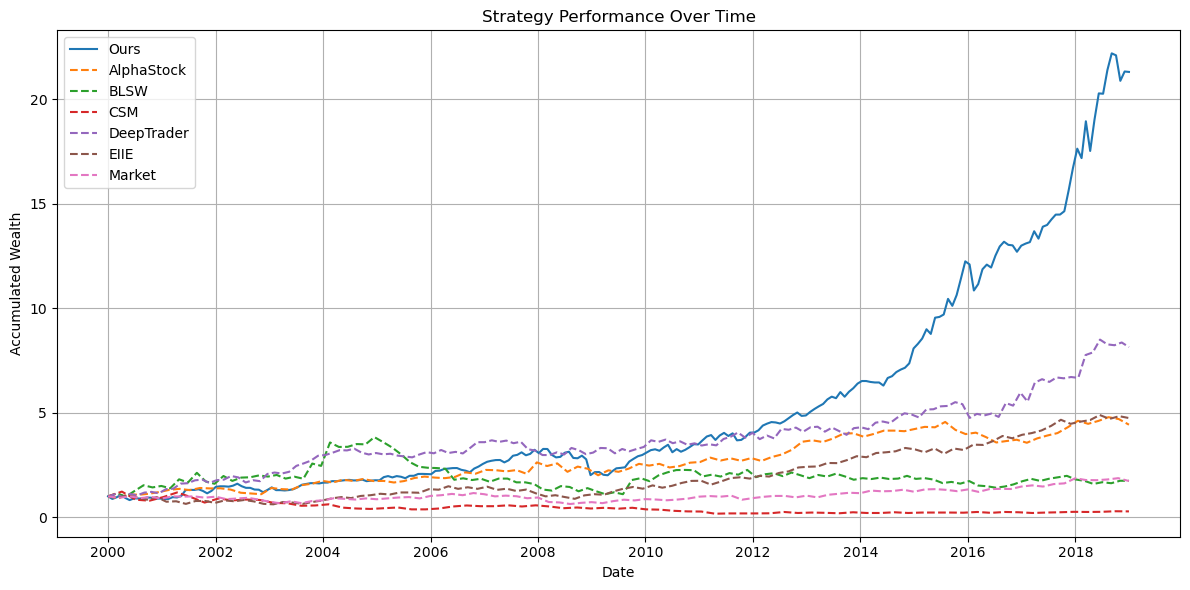

In [10]:
plot_cumulative_wealth(
    returns_dict={
        # 'Signal Predictor': realized_returns_signal_predictor
    }, 
    start_time=config.data_config.val_set_last_date, 
    end_time=config.data_config.end,
    ours_to_include=['Ours'],
    compare_to_baseline=True
)

In [ ]:
realized_returns_signal_predictor

In [13]:
root_dir = '../modeling/rl/visualization'
realized_returns_signal_predictor = \
    list(pd.read_csv(os.path.join(root_dir, f'results_ours', f'realized_returns_ours-na.csv'))['0'])

In [14]:
metrics = MetricsCalculator(
    metrics=DEFAULT_METRICS
)(realized_returns_signal_predictor)
metrics

{'CumulativeReturn': 14.443480491638184,
 'MeanReturnPercentage': 1.311758067458868,
 'ARR': 0.1486550586921611,
 'AVOL': 0.1894192864654605,
 'MDD': 36.71503663063049,
 'ASR': 0.7847936789650377,
 'CR': 0.004048887658418995,
 'DDR': 0.942922499771055,
 'SoR': 0.2882309854030609}

In [5]:
0.1675 / 0.3853

0.4347261873864522

In [ ]:
sum(actions_signal_predictor[0])

In [ ]:
plot_position_heatmap(actions_signal_predictor, asset_names=sorted(list(retrieval_result.keys())))

In [ ]:
import copy  # Local import to avoid polluting global namespace unnecessarily
state_dict = (
    model.module.state_dict()
        if isinstance(model, torch.nn.DataParallel)
    else model.state_dict()
)

# Keep a local copy of the best weights so we can return the best model
# after training finishes, without needing to reload from disk.
best_model_state = copy.deepcopy(state_dict)

# Persist to disk if a save_path was provided
torch.save(state_dict, "best_model.pth")